In [1]:
import gc
import time
import keras as k
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import mean_squared_error, \
                confusion_matrix, classification_report

pd.set_option('display.max_columns', None)

Using TensorFlow backend.


# Inspecting Data

In [2]:
df = pd.read_csv('data/FinalDataset.csv',index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1770 entries, 12/27/2013 to 10/31/2018
Columns: 132 entries, com_count to bitcoin_market_cap
dtypes: float64(65), int64(67)
memory usage: 1.8+ MB


In [3]:
df.head()

,com_count,sub_count,com_body_pos_count,com_body_very_pos_count,com_body_neg_count,com_body_very_neg_count,sub_body_pos_count,sub_body_very_pos_count,sub_body_neg_count,sub_body_very_neg_count,sub_title_pos_count,sub_title_very_pos_count,sub_title_neg_count,sub_title_very_neg_count,sub_title_non_zero_pr,sub_title_top_50_pr,sub_title_top_75_pr,sub_title_pr_4_bins,sub_title_pr_normalized,sub_title_pr_norm_plus_base,sub_title_pos_non_zero_pr,sub_title_pos_top_50_pr,sub_title_pos_top_75_pr,sub_title_pos_pr_4_bins,sub_title_pos_pr_normalized,sub_title_pos_pr_norm_plus_base,sub_title_very_pos_non_zero_pr,sub_title_very_pos_top_50_pr,sub_title_very_pos_top_75_pr,sub_title_very_pos_pr_4_bins,sub_title_very_pos_pr_normalized,sub_title_very_pos_pr_norm_plus_base,sub_title_neg_non_zero_pr,sub_title_neg_top_50_pr,sub_title_neg_top_75_pr,sub_title_neg_pr_4_bins,sub_title_neg_pr_normalized,sub_title_neg_pr_norm_plus_base,sub_title_very_neg_non_zero_pr,sub_title_very_neg_top_50_pr,sub_title_very_neg_top_75_pr,sub_title_very_neg_pr_4_bins,sub_title_very_neg_pr_normalized,sub_title_very_neg_pr_norm_plus_base,sub_title_very_pos_minus_very_neg_non_zero_pr,sub_title_pos_minus_neg_non_zero_pr,sub_title_pos_non_zero_pr_percent,sub_title_very_pos_non_zero_pr_percent,sub_title_neg_non_zero_pr_percent,sub_title_very_neg_non_zero_pr_percent,sub_body_non_zero_pr,sub_body_top_50_pr,sub_body_top_75_pr,sub_body_pr_4_bins,sub_body_pr_normalized,sub_body_pr_norm_plus_base,sub_body_pos_non_zero_pr,sub_body_pos_top_50_pr,sub_body_pos_top_75_pr,sub_body_pos_pr_4_bins,sub_body_pos_pr_normalized,sub_body_pos_pr_norm_plus_base,sub_body_very_pos_non_zero_pr,sub_body_very_pos_top_50_pr,sub_body_very_pos_top_75_pr,sub_body_very_pos_pr_4_bins,sub_body_very_pos_pr_normalized,sub_body_very_pos_pr_norm_plus_base,sub_body_neg_non_zero_pr,sub_body_neg_top_50_pr,sub_body_neg_top_75_pr,sub_body_neg_pr_4_bins,sub_body_neg_pr_normalized,sub_body_neg_pr_norm_plus_base,sub_body_very_neg_non_zero_pr,sub_body_very_neg_top_50_pr,sub_body_very_neg_top_75_pr,sub_body_very_neg_pr_4_bins,sub_body_very_neg_pr_normalized,sub_body_very_neg_pr_norm_plus_base,sub_body_very_pos_minus_very_neg_non_zero_pr,sub_body_pos_minus_neg_non_zero_pr,sub_body_pos_non_zero_pr_percent,sub_body_very_pos_non_zero_pr_percent,sub_body_neg_non_zero_pr_percent,sub_body_very_neg_non_zero_pr_percent,com_body_non_zero_pr,com_body_top_50_pr,com_body_top_75_pr,com_body_pr_4_bins,com_body_pr_normalized,com_body_pr_norm_plus_base,com_body_pos_non_zero_pr,com_body_pos_top_50_pr,com_body_pos_top_75_pr,com_body_pos_pr_4_bins,com_body_pos_pr_normalized,com_body_pos_pr_norm_plus_base,com_body_very_pos_non_zero_pr,com_body_very_pos_top_50_pr,com_body_very_pos_top_75_pr,com_body_very_pos_pr_4_bins,com_body_very_pos_pr_normalized,com_body_very_pos_pr_norm_plus_base,com_body_neg_non_zero_pr,com_body_neg_top_50_pr,com_body_neg_top_75_pr,com_body_neg_pr_4_bins,com_body_neg_pr_normalized,com_body_neg_pr_norm_plus_base,com_body_very_neg_non_zero_pr,com_body_very_neg_top_50_pr,com_body_very_neg_top_75_pr,com_body_very_neg_pr_4_bins,com_body_very_neg_pr_normalized,com_body_very_neg_pr_norm_plus_base,com_body_very_pos_minus_very_neg_non_zero_pr,com_body_pos_minus_neg_non_zero_pr,com_body_pos_non_zero_pr_percent,com_body_very_pos_non_zero_pr_percent,com_body_neg_non_zero_pr_percent,com_body_very_neg_non_zero_pr_percent,avg_clust_coef,avg_degree,num_edges,num_nodes,bitcoin_open,bitcoin_high,bitcoin_low,bitcoin_close,bitcoin_volume,bitcoin_market_cap
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12/27/2013,6065,477,1516,766,666,253,105,74,14,6,67,10,22,4,151,15,1,96.25,0.584285,4.434285,14,3,0,13.0,0.075103,0.595103,1,0,0,1.75,0.000659,0.070659,9,1,0,4.25,0.025917,0.195917,1,0,0,0.75,0.000924,0.030924,0,5,0.092715,0.006623,0.059603,0.006623,151,15,1,96.25,0.584285,4.434285,36,2,0,21.00,0.107567,0.947567,27,1,0,14.00,0.072764,0.632764,2,0,0,2.75,0.

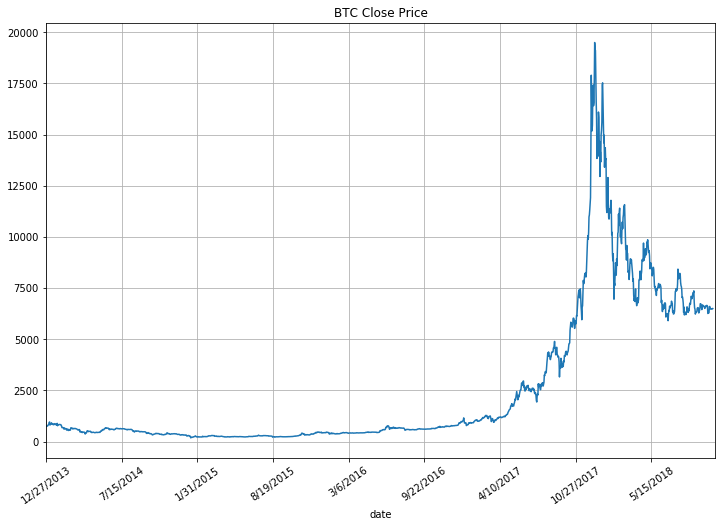

In [4]:
# show closing price time series
df['bitcoin_close'].plot(title='BTC Close Price',grid=True,rot=35, figsize=(12,8))

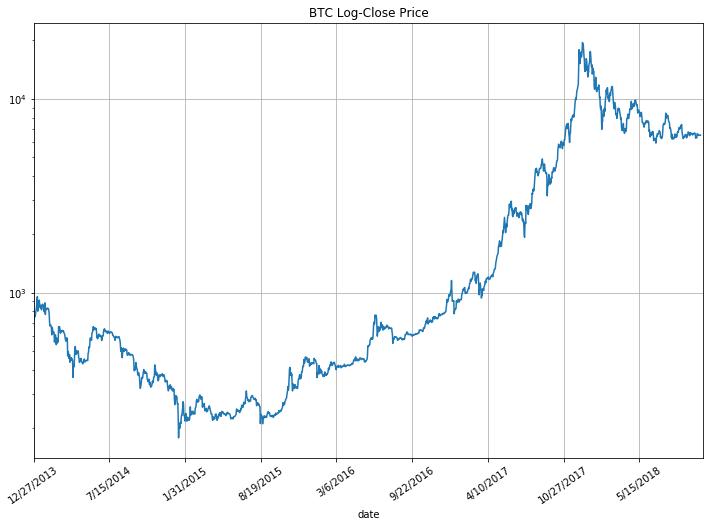

In [5]:
# show log-closing price time series
df['bitcoin_close'].plot(title='BTC Log-Close Price',grid=True,logy=True,rot=35, figsize=(12,8))

In [6]:
# stats on time series length
print("number of days:  {:.1f}".format(df.shape[0]))
print("number of months:  {:.1f}".format(df.shape[0] / 30))
print("number of years:    {:.1f}".format(df.shape[0] / 365))

number of days:  1770.0
number of months:  59.0
number of years:    4.8


# Defining Functions

## Loading and Preparing Data

In [7]:
# function to read in dataset

def get_data():
    return pd.read_csv('data/FinalDataset.csv',index_col='date')

In [8]:
# function to drop unneeded fields

def keep_only_close(df_in):
    drops = ['bitcoin_open', 'bitcoin_high', 'bitcoin_low',
             'bitcoin_volume', 'bitcoin_market_cap']
    return df_in.drop(drops, axis=1) 

In [9]:
# function to add predicted column for tomorrow's close price

def add_prediction_field(df_in):
    # creating predicted value
    # create column to hold tomorrow's close for each day
    df_in['tomorrow_close'] = df_in['bitcoin_close'].shift(-1)
    # change in price between consecutive closing days
    df_in['day_change'] = df_in['tomorrow_close'] - df_in['bitcoin_close']
    # indicator variable to be used for predicting higher/lower days
    df_in['y'] = np.where(df_in['day_change'] >= 0, 1, 0)
        
    # drop intermediate columns
    return df_in.drop(['tomorrow_close', 'day_change'], axis=1)

In [10]:
# function to add lags for daily features

def add_lags(df_in, n_lags=0):
    # splitting into X/y for separate processing
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    # save list of columns for lags
    col_list = X.columns
    # create output DF
    df_out = X.copy()
    
    # creating lags
    # create lag columns for each other variable
    for lag in range(n_lags):
        for col in col_list:
            df_out['{}_(-{})'.format(col,lag+1)] = df_out[col].shift(lag+1)

    # return and drop na
    df_out['y'] = y
    return df_out.dropna()

In [11]:
# function to remove data before certain date

def truncate_date(df_in, first_day='1999-1-1'):
    # set mask of Bool values
    mask = (pd.to_datetime(df_in.index) >= first_day)
    return df_in.loc[mask]

In [12]:
# function to rejoin training data into X/y again

def rejoin_training_data(X_train, X_test, y_train, y_test):
    Xs = [X_train, X_test]
    Ys = [y_train, y_test]
    
    df_out = pd.concat(Xs)
    df_out['y'] = pd.concat(Ys)
    
    return df_out

In [13]:
# function to create train/test X and y
def create_training_data(df_in, n_lags=0, train_split=0.7, rescale=True, k_feat_perc=None):
    # split into test train
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    timesteps = n_lags + 1
    
    # determine cutoff of train/test split and split
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]
    
    # scale values to 0-1
    # must only scale based on training data, to ensure no 
    # foresight with averages
    if rescale:
        scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train.values)
        cols = X.columns
        X_train = pd.DataFrame(scaler.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(scaler.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # select top K features to use
    if k_feat_perc:
        selector = SelectPercentile(chi2, percentile=k_feat_perc).fit(
                                    X_train.values,y_train.values)
        # index and names of remainig columns after filter
        cols = X_train.columns[selector.get_support(indices = True)]
        X_train = pd.DataFrame(selector.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(selector.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # recreate into X/y DF and add lags
    df_renew = rejoin_training_data(X_train, X_test, y_train, y_test)
    df_renew = add_lags(df_renew, n_lags=n_lags)
    
    # split into test train again
    X, y = df_renew[df_renew.columns[:-1]], df_renew[df_renew.columns[-1]]
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]
    
    # extract values of X and y
    X_train, X_test = X_train.values, X_test.values
    y_train, y_test = y_train.values, y_test.values

    
    # reshape input to be LSTM format [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], timesteps, int(X_train.shape[1]/timesteps)))
    X_test = X_test.reshape((X_test.shape[0], timesteps, int(X_test.shape[1]/timesteps)))
    
    # display shapes
    print('='*65)
    print('New Training Set')
    print('Training Set Dims: {}'.format(X_train.shape))
    print('Testing Set Dims:  {}'.format(X_test.shape))
    print('='*65)

    return X_train, X_test, y_train, y_test

In [14]:
# function to prep data and return DF for modeling

def prepare_data(n_lags=0, train_split=0.7, close_o=False, 
                         first_day=None, rescale=True, k_feat_perc=None):
    # read in  dataset and initialize output df
    df_in = get_data()
    df_out = pd.DataFrame()
    
    # drop non-price fields if needed
    if close_o:
        df_in = keep_only_close(df_in)
    
    # add prediction field
    df_in = add_prediction_field(df_in)
    
    # cut off prior to first_day
    if first_day:
        df_in = truncate_date(df_in, first_day)
    
    return create_training_data(df_in, n_lags=n_lags, train_split=train_split, 
                                rescale=rescale, k_feat_perc=k_feat_perc)

## Preparing Data for Training

In [15]:
# split dataset
X_train, X_test, y_train, y_test = prepare_data(n_lags=3, train_split=0.8, close_o=False, 
                                    first_day='2016-1-1', rescale=True, k_feat_perc=50)

New Training Set
Training Set Dims: (820, 4, 48)
Testing Set Dims:  (205, 4, 48)


In [16]:
X_train.shape

(820, 4, 48)

In [17]:
X_test.shape

(205, 4, 48)

In [18]:
y_train.shape

(820,)

In [19]:
y_test.shape

(205,)

In [20]:
# balance of dependent variable values
ones = y_train.sum()
zeros = y_train.shape[0] - ones
print("0's: {}".format(zeros))
print("1's: {}".format(ones))

0's: 339
1's: 481


In [21]:
# balance of dependent variable values
ones = y_test.sum()
zeros = y_test.shape[0] - ones
print("0's: {}".format(zeros))
print("1's: {}".format(ones))

0's: 98
1's: 107


## Build, Train, Test LSTM Model

In [22]:
# function to create and train model

def run_model(lstm_neurs=100, dense_neurs=10, dropout_lstm=0.2, dropout_dense1=0.2, dropout_dense2=0.2,\
              dropout_recurr=0.2, l2_lstm=0.01, l2_dense=0.01, batch_size=14, \
              kernel_initializer='glorot_uniform', epochs=10):
    # create LSTM model
    model = Sequential()
    model.add(LSTM(lstm_neurs, kernel_initializer=kernel_initializer, 
                   input_shape=(X_train.shape[1], X_train.shape[2]), 
                   dropout=dropout_lstm, recurrent_dropout=dropout_recurr,
                    kernel_regularizer=regularizers.l2(l2_lstm)))
    model.add(Dropout(dropout_dense1))
    model.add(Dense(dense_neurs, activation='relu', kernel_regularizer=regularizers.l2(l2_dense)))
    model.add(Dropout(dropout_dense2))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model and output summary 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    # fit model and evaluate
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,shuffle=False)
    scores = model.evaluate(X_test, y_test, verbose=2)
    y_pred = np.round(model.predict(X_test))
    accuracy = scores[1] * 100
    print("\nAccuracy: {:.2f}%".format(accuracy))
    
    # print confusion matrix
    print('\nConfusion Matrix')
    print('='*20)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                       index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes']))
    
    # print classification report
    print('\nClasification Report')
    print('='*20)
    print(classification_report(y_test, y_pred, labels=[0,1]))
    
    return model, accuracy

In [23]:
model,acc  = run_model(lstm_neurs=100, dense_neurs=10, dropout_lstm=0.2, dropout_dense1=0.2, dropout_dense2=0.2,\
              dropout_recurr=0.2, l2_lstm=0.01, l2_dense=0.01, batch_size=30, \
              kernel_initializer='glorot_uniform', epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               59600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 60,621
Trainable params: 60,621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
820/820 [==============================] - 3s 4ms/step - loss: 1.4755 - acc: 0.5646
Epoch 2/10
820/820 [==================

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Optimizing Training and LSTM Model Parameters

In [24]:
def run_simulations(n_lags=0, k_feat_perc=0.5, uniques=True, 
                    timer=True, close_o=False, first_day=None):
    # run all simulations to find best model
    if timer:
        start = time.time()
    
    # train/test splits
    train_splits = [0.75, 0.9]
    
    # neurons
    # number of neurons in LSTM
    lstm_neurons = [5, 10, 50, 100]
    # number of neurons in Dense
    dense_neurons = [3, 5, 10]
    
    # dropouts
    # dropout of LSTM layer
    dropout_lstm = [0.2]
    # dropout of layer before Dense layer
    dropout_dense1 = [0.2]
    # dropout of layer after Dense layer
    dropout_dense2 = [0.3]
    # dropout in recurrent layer of LSTM
    dropout_recurr = [0.2]
    
    # training and initializers
    # batch size of iterations
    batch_size = [30]
    # kernel initializers for LSTM layer
    kernel_initializer=['glorot_uniform', 'glorot_normal',
                        'zeros']
    
    # regularization
    # regularization penalties for LSTM layer
    l2s_lstms = [0.2]
    # regularization penalties for Dense layer
    l2s_denses = [0.2]
    
    # misc
    # epochs for iterations
    epochs = [5]
    # dashes for formatting
    dashes = 65
    
    # RUN
    # number of reports to keep track
    report = 0
    accs = set()
    
    # data preparation parameters

    # read in data and create lags
    for split in train_splits:
        # create training and test data
        X_train, X_test, y_train, y_test = prepare_data(n_lags=n_lags, 
                                train_split=split, close_o=close_o, 
                                first_day=first_day, rescale=True, k_feat_perc=k_feat_perc)

        # run all simulations of for modeling parameters
        for lstm_n in lstm_neurons:
            for dense_n in dense_neurons:
                for d_lstm in dropout_lstm:
                    for d_dense1 in dropout_dense1:
                        for d_dense2 in dropout_dense2:
                            for d_recurr in dropout_recurr:
                                for l2_lstm in l2s_lstms:
                                    for l2_dense in l2s_denses:
                                        for batch in batch_size:
                                            for k_init in kernel_initializer:
                                                for e in epochs:
                                                    # print output
                                                    report += 1
                                                    print('='*dashes)
                                                    print('REPORT # {}'.format(report))
                                                    print('='*dashes)
                                                    print('Training Parameters')
                                                    print('Number of lags    = {}'.format(n_lags))
                                                    print('Training Data %   = {:0.1f}%'.format(split*100))
                                                    print('='*dashes)
                                                    print('Model Parameters')
                                                    print('LSTM Neurons      = {}'.format(lstm_n))
                                                    print('Dense Neurons     = {}'.format(dense_n))
                                                    print('Dropout LSTM      = {}'.format(d_lstm))
                                                    print('Dropout Dense1    = {}'.format(d_dense1))
                                                    print('Dropout Dense2    = {}'.format(d_dense2))
                                                    print('Dropout Recurrent = {}'.format(d_recurr))
                                                    print('L2 - LSTM Layer   = {}'.format(l2_lstm))
                                                    print('L2 - Dense Layer  = {}'.format(l2_dense))
                                                    print('Batch Size        = {}'.format(batch))
                                                    print('Kernel Init.      = {}'.format(k_init))
                                                    print('Epochs            = {}'.format(e))
                                                    print('='*dashes)
                                                    # execute model
                                                    model, acc = run_model(lstm_neurs=lstm_n, dense_neurs=dense_n, \
                                                              dropout_lstm=d_lstm, dropout_dense1=d_dense1, \
                                                              dropout_dense2=d_dense2, dropout_recurr=d_recurr, \
                                                              l2_lstm=l2_lstm, l2_dense=l2_dense, batch_size=batch, \
                                                              kernel_initializer=k_init, epochs=e)
                                                    # update minimum accuracy and skip over
                                                    # any models with same as previous accuracy scores
                                                    if acc in accs and uniques: continue
                                                    if close_o:
                                                        model.save('models-full/close_only/'\
                                                                   'model-{}_lags-{}_feat-{}_acc-{}.h5'.format(
                                                                    report, n_lags, X_train.shape[2],round(acc)))
                                                    else:
                                                        model.save('models-full/full/'\
                                                                   'model-{}_lags-{}_feat-{}_acc-{}.h5'.format(
                                                            report, n_lags, X_train.shape[2], round(acc)))
                                                    accs.add(acc)
                                                    model, acc = None, None
                                                    gc.collect()
                                                    print('='*dashes)
    if timer:
        end = time.time()
        print('Process took {:.2f} seconds'.format(end-start))

## Running Parameter Sweeps

## 0 Lags

### Full Price Data

In [25]:
# run all simulations for 0 lags and 50% attributes
run_simulations(n_lags=0, k_feat_perc=50, uniques=True, 
                timer=True, close_o=False, first_day='2016-1-1')
gc.collect()

New Training Set
Training Set Dims: (771, 1, 48)
Testing Set Dims:  (257, 1, 48)
REPORT # 1
Training Parameters
Number of lags    = 0
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_uniform
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5)                 1080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 18        
_________________________________________________________________
dropout_4 (Dropout)        

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


REPORT # 2
Training Parameters
Number of lags    = 0
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_normal
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5)                 1080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 18        
_________________________________________________________________
dropout_6 (Dropout)          (None, 3)                 0         
___________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5)                 1080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 30        
_________________________________________________________________
dropout_12 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 1,116
Trainable params: 1,116
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 2s 2ms/step - loss: 6.1319 - acc: 0.5476
Epoch 2/5
820/820 [======================

Epoch 1/5
820/820 [==============================] - 2s 3ms/step - loss: 6.8485 - acc: 0.5720
Epoch 2/5
820/820 [==============================] - 0s 407us/step - loss: 5.4713 - acc: 0.5902
Epoch 3/5
820/820 [==============================] - 0s 434us/step - loss: 4.4029 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 0s 381us/step - loss: 3.5769 - acc: 0.5878
Epoch 5/5
820/820 [==============================] - 0s 397us/step - loss: 2.9390 - acc: 0.5878

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 9
Training Parameters
Number of lags    = 0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 10)                2360      
_________________________________________________________________
dropout_31 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 55        
_________________________________________________________________
dropout_32 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 6         
Total params: 2,421
Trainable params: 2,421
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 3s 4ms/step - loss: 1.6544 - acc: 0.5646
Epoch 2/5
820/820 [======================

Epoch 1/5
820/820 [==============================] - 3s 4ms/step - loss: 2.2180 - acc: 0.5646
Epoch 2/5
820/820 [==============================] - 0s 394us/step - loss: 1.9778 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 0s 392us/step - loss: 1.7728 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 0s 461us/step - loss: 1.5990 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 0s 397us/step - loss: 1.4510 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 19
Training Parameters
Number of lags    = 0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 50)                19800     
_________________________________________________________________
dropout_51 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_52 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 11        
Total params: 20,321
Trainable params: 20,321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 4s 5ms/step - loss: 15.8050 - acc: 0.5012A: 3s - loss: 17.4922 - acc: 
Epoch 2/5

Epoch 1/5
820/820 [==============================] - 5s 6ms/step - loss: 14.2429 - acc: 0.5659
Epoch 2/5
820/820 [==============================] - 0s 475us/step - loss: 6.7755 - acc: 0.5854
Epoch 3/5
820/820 [==============================] - 0s 402us/step - loss: 3.2459 - acc: 0.5854
Epoch 4/5
820/820 [==============================] - 0s 403us/step - loss: 1.7306 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 0s 464us/step - loss: 1.1172 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 29
Training Parameters
Number of lags    = 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 100)               59600     
_________________________________________________________________
dropout_71 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 10)                1010      
_________________________________________________________________
dropout_72 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 11        
Total params: 60,621
Trainable params: 60,621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 6s 7ms/step - loss: 16.3764 - acc: 0.5378
Epoch 2/5
820/820 [===================

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 5)                 1080      
_________________________________________________________________
dropout_77 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_77 (Dense)             (None, 3)                 18        
_________________________________________________________________
dropout_78 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 4         
Total params: 1,102
Trainable params: 1,102
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 6s 7ms/step - loss: 5.9307 - acc: 0.5866
Epoch 2/5
820/820 [======================

Epoch 1/5
820/820 [==============================] - 6s 8ms/step - loss: 6.6409 - acc: 0.5732
Epoch 2/5
820/820 [==============================] - 0s 440us/step - loss: 5.3278 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 0s 472us/step - loss: 4.3141 - acc: 0.5878
Epoch 4/5
820/820 [==============================] - 0s 447us/step - loss: 3.5382 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 0s 442us/step - loss: 2.9390 - acc: 0.5854

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 42
Training Parameters
Number of lags    = 0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 10)                2360      
_________________________________________________________________
dropout_97 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 3)                 33        
_________________________________________________________________
dropout_98 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 4         
Total params: 2,397
Trainable params: 2,397
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 8s 9ms/step - loss: 1.5233 - acc: 0.5646
Epoch 2/5
820/820 [======================

Epoch 1/5
820/820 [==============================] - 8s 10ms/step - loss: 1.9644 - acc: 0.5646
Epoch 2/5
820/820 [==============================] - 0s 457us/step - loss: 1.7996 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 0s 488us/step - loss: 1.6543 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 0s 456us/step - loss: 1.5269 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 0s 488us/step - loss: 1.4150 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 52
Training Parameters
Number of lags    = 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 50)                19800     
_________________________________________________________________
dropout_117 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 5)                 255       
_________________________________________________________________
dropout_118 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_118 (Dense)            (None, 1)                 6         
Total params: 20,061
Trainable params: 20,061
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 9s 11ms/step - loss: 14.5508 - acc: 0.4537
Epoch 2/5
820/820 [==================

Epoch 1/5
820/820 [==============================] - 10s 12ms/step - loss: 15.6279 - acc: 0.5476
Epoch 2/5
820/820 [==============================] - 0s 472us/step - loss: 9.4084 - acc: 0.5902
Epoch 3/5
820/820 [==============================] - 0s 523us/step - loss: 5.6865 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 0s 466us/step - loss: 3.5525 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 0s 477us/step - loss: 2.3417 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 62
Training Parameters
Number of lags    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_69 (LSTM)               (None, 100)               59600     
_________________________________________________________________
dropout_137 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_137 (Dense)            (None, 5)                 505       
_________________________________________________________________
dropout_138 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_138 (Dense)            (None, 1)                 6         
Total params: 60,111
Trainable params: 60,111
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 11s 14ms/step - loss: 14.9290 - acc: 0.5841
Epoch 2/5
820/820 [=================

Epoch 1/5
820/820 [==============================] - 12s 15ms/step - loss: 16.4371 - acc: 0.5878
Epoch 2/5
820/820 [==============================] - 0s 531us/step - loss: 8.7296 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 0s 492us/step - loss: 4.7753 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 0s 503us/step - loss: 2.7816 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 0s 523us/step - loss: 1.7711 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 72
Training Parameters
Number of lags    

847

### Only Close

In [26]:
# run all simulations for 0 lags and 50% attributes
run_simulations(n_lags=0, k_feat_perc=50, uniques=True, 
                timer=True, close_o=True, first_day='2016-1-1')
gc.collect()

New Training Set
Training Set Dims: (771, 1, 45)
Testing Set Dims:  (257, 1, 45)
REPORT # 1
Training Parameters
Number of lags    = 0
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_uniform
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, 5)                 1080      
_________________________________________________________________
dropout_147 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_147 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_148 (Dropout)      

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


REPORT # 2
Training Parameters
Number of lags    = 0
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_normal
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 5)                 1080      
_________________________________________________________________
dropout_149 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_149 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_150 (Dropout)        (None, 3)                 0         
___________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 5)                 1080      
_________________________________________________________________
dropout_155 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_155 (Dense)            (None, 5)                 30        
_________________________________________________________________
dropout_156 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_156 (Dense)            (None, 1)                 6         
Total params: 1,116
Trainable params: 1,116
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 13s 16ms/step - loss: 6.7752 - acc: 0.5159
Epoch 2/5
820/820 [====================

Epoch 1/5
820/820 [==============================] - 14s 17ms/step - loss: 7.0055 - acc: 0.5183
Epoch 2/5
820/820 [==============================] - 0s 548us/step - loss: 5.6104 - acc: 0.5476
Epoch 3/5
820/820 [==============================] - 0s 486us/step - loss: 4.5268 - acc: 0.5744
Epoch 4/5
820/820 [==============================] - 0s 541us/step - loss: 3.6880 - acc: 0.5878
Epoch 5/5
820/820 [==============================] - 0s 488us/step - loss: 3.0431 - acc: 0.5878

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 9
Training Parameters
Number of lags    = 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 10)                2360      
_________________________________________________________________
dropout_175 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_175 (Dense)            (None, 5)                 55        
_________________________________________________________________
dropout_176 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_176 (Dense)            (None, 1)                 6         
Total params: 2,421
Trainable params: 2,421
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 15s 19ms/step - loss: 2.0718 - acc: 0.5646
Epoch 2/5
820/820 [====================

Epoch 1/5
820/820 [==============================] - 16s 19ms/step - loss: 2.9030 - acc: 0.5646
Epoch 2/5
820/820 [==============================] - 0s 579us/step - loss: 2.5955 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 0s 512us/step - loss: 2.3256 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 0s 544us/step - loss: 2.0909 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 0s 531us/step - loss: 1.8869 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 19
Training Parameters
Number of lags    =

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_98 (LSTM)               (None, 50)                19800     
_________________________________________________________________
dropout_195 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_195 (Dense)            (None, 10)                510       
_________________________________________________________________
dropout_196 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_196 (Dense)            (None, 1)                 11        
Total params: 20,321
Trainable params: 20,321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 18s 22ms/step - loss: 15.9567 - acc: 0.4073
Epoch 2/5
820/820 [=================

Epoch 1/5
820/820 [==============================] - 19s 24ms/step - loss: 14.0205 - acc: 0.5976
Epoch 2/5
820/820 [==============================] - 0s 575us/step - loss: 6.6228 - acc: 0.5854
Epoch 3/5
820/820 [==============================] - 0s 534us/step - loss: 3.1560 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 0s 579us/step - loss: 1.6855 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 0s 558us/step - loss: 1.0921 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 29
Training Parameters
Number of lags    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_108 (LSTM)              (None, 100)               59600     
_________________________________________________________________
dropout_215 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_215 (Dense)            (None, 10)                1010      
_________________________________________________________________
dropout_216 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_216 (Dense)            (None, 1)                 11        
Total params: 60,621
Trainable params: 60,621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 21s 25ms/step - loss: 16.4297 - acc: 0.5646
Epoch 2/5
820/820 [=================

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_111 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_221 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_221 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_222 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_222 (Dense)            (None, 1)                 4         
Total params: 1,102
Trainable params: 1,102
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 21s 26ms/step - loss: 6.6283 - acc: 0.5561
Epoch 2/5
820/820 [====================

Epoch 1/5
820/820 [==============================] - 22s 27ms/step - loss: 6.5916 - acc: 0.5500
Epoch 2/5
820/820 [==============================] - 0s 607us/step - loss: 5.2970 - acc: 0.5890
Epoch 3/5
820/820 [==============================] - 0s 569us/step - loss: 4.2960 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 1s 633us/step - loss: 3.5300 - acc: 0.5744
Epoch 5/5
820/820 [==============================] - 0s 590us/step - loss: 2.9332 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 42
Training Parameters
Number of lags    =

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_121 (LSTM)              (None, 10)                2360      
_________________________________________________________________
dropout_241 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_241 (Dense)            (None, 3)                 33        
_________________________________________________________________
dropout_242 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_242 (Dense)            (None, 1)                 4         
Total params: 2,397
Trainable params: 2,397
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 24s 29ms/step - loss: 1.6546 - acc: 0.5646
Epoch 2/5
820/820 [====================

Epoch 1/5
820/820 [==============================] - 25s 30ms/step - loss: 2.2101 - acc: 0.5646
Epoch 2/5
820/820 [==============================] - 0s 597us/step - loss: 2.0319 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 1s 637us/step - loss: 1.8724 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 0s 609us/step - loss: 1.7306 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 657us/step - loss: 1.6044 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 52
Training Parameters
Number of lags    =

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 50)                19800     
_________________________________________________________________
dropout_261 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_261 (Dense)            (None, 5)                 255       
_________________________________________________________________
dropout_262 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_262 (Dense)            (None, 1)                 6         
Total params: 20,061
Trainable params: 20,061
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 28s 34ms/step - loss: 14.4779 - acc: 0.5671
Epoch 2/5
820/820 [=================

Epoch 1/5
820/820 [==============================] - 29s 36ms/step - loss: 16.0185 - acc: 0.5549
Epoch 2/5
820/820 [==============================] - 1s 669us/step - loss: 9.7082 - acc: 0.5902
Epoch 3/5
820/820 [==============================] - 1s 654us/step - loss: 5.9120 - acc: 0.5890
Epoch 4/5
820/820 [==============================] - 1s 676us/step - loss: 3.7185 - acc: 0.5902
Epoch 5/5
820/820 [==============================] - 1s 655us/step - loss: 2.4668 - acc: 0.5829

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 62
Training Parameters
Number of lags    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_141 (LSTM)              (None, 100)               59600     
_________________________________________________________________
dropout_281 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_281 (Dense)            (None, 5)                 505       
_________________________________________________________________
dropout_282 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_282 (Dense)            (None, 1)                 6         
Total params: 60,111
Trainable params: 60,111
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 32s 38ms/step - loss: 15.0091 - acc: 0.5146
Epoch 2/5
820/820 [=================

Epoch 1/5
820/820 [==============================] - 30s 36ms/step - loss: 16.7093 - acc: 0.51950s - loss: 16.7666 - acc: 0.52
Epoch 2/5
820/820 [==============================] - 1s 736us/step - loss: 8.9013 - acc: 0.5890
Epoch 3/5
820/820 [==============================] - 1s 706us/step - loss: 4.8718 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 1s 741us/step - loss: 2.8382 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 730us/step - loss: 1.8026 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 72
Training

322

## 3 Lags

### Full Price Data

In [27]:
# run all simulations for 3 lags and 50% attributes
run_simulations(n_lags=3, k_feat_perc=50, uniques=True, 
                timer=True, close_o=False, first_day='2016-1-1')
gc.collect()

New Training Set
Training Set Dims: (768, 4, 48)
Testing Set Dims:  (257, 4, 48)
REPORT # 1
Training Parameters
Number of lags    = 3
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_uniform
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_146 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_291 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_291 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_292 (Dropout)      

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


REPORT # 2
Training Parameters
Number of lags    = 3
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_normal
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_147 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_293 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_293 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_294 (Dropout)        (None, 3)                 0         
___________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_150 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_299 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_299 (Dense)            (None, 5)                 30        
_________________________________________________________________
dropout_300 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_300 (Dense)            (None, 1)                 6         
Total params: 1,116
Trainable params: 1,116
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 34s 42ms/step - loss: 7.0329 - acc: 0.5537
Epoch 2/5
820/820 [====================

Epoch 1/5
820/820 [==============================] - 35s 43ms/step - loss: 7.0183 - acc: 0.5293
Epoch 2/5
820/820 [==============================] - 1s 731us/step - loss: 5.6365 - acc: 0.5817 0s - loss: 5.8802 - acc: 0.
Epoch 3/5
820/820 [==============================] - 1s 770us/step - loss: 4.5638 - acc: 0.5817
Epoch 4/5
820/820 [==============================] - 1s 711us/step - loss: 3.7358 - acc: 0.5878
Epoch 5/5
820/820 [==============================] - 1s 772us/step - loss: 3.0919 - acc: 0.5854

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 9
Training Par

820/820 [==============================] - 1s 747us/step - loss: 3.4389 - acc: 0.5841

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 15
Training Parameters
Number of lags    = 3
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 10
Dense Neurons     = 5
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = zeros
Epochs            = 5
_________________________________________________________________
Layer (type)          

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_163 (LSTM)              (None, 10)                2360      
_________________________________________________________________
dropout_325 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_325 (Dense)            (None, 10)                110       
_________________________________________________________________
dropout_326 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_326 (Dense)            (None, 1)                 11        
Total params: 2,481
Trainable params: 2,481
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 40s 49ms/step - loss: 2.4521 - acc: 0.5646
Epoch 2/5
820/820 [====================

Epoch 1/5
820/820 [==============================] - 42s 51ms/step - loss: 1.8025 - acc: 0.5646
Epoch 2/5
820/820 [==============================] - 1s 825us/step - loss: 1.5461 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 1s 782us/step - loss: 1.3422 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 1s 828us/step - loss: 1.1830 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 851us/step - loss: 1.0593 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 22
Training Parameters
Number of lags    =

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_173 (LSTM)              (None, 100)               59600     
_________________________________________________________________
dropout_345 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_345 (Dense)            (None, 3)                 303       
_________________________________________________________________
dropout_346 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_346 (Dense)            (None, 1)                 4         
Total params: 59,907
Trainable params: 59,907
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 44s 54ms/step - loss: 14.1542 - acc: 0.5732
Epoch 2/5
820/820 [=================

Epoch 1/5
820/820 [==============================] - 46s 56ms/step - loss: 14.7392 - acc: 0.5598
Epoch 2/5
820/820 [==============================] - 1s 890us/step - loss: 7.1196 - acc: 0.5744
Epoch 3/5
820/820 [==============================] - 1s 895us/step - loss: 3.4952 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 1s 859us/step - loss: 1.9029 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 875us/step - loss: 1.2352 - acc: 0.5866 0s - loss: 1.3640 - acc: 

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 32
Training Par

820/820 [==============================] - 1s 948us/step - loss: 4.0317 - acc: 0.5659 0s - loss: 4.1643 - acc: 0.5
Epoch 4/5
820/820 [==============================] - 1s 968us/step - loss: 3.2340 - acc: 0.5793 0s - loss: 3.2380 - acc: 0.580
Epoch 5/5
820/820 [==============================] - 1s 938us/step - loss: 2.6285 - acc: 0.5720

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 38
Training Parameters
Number of lags    = 3
Training Data %   = 90.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Drop

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_183 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_365 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_365 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_366 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_366 (Dense)            (None, 1)                 4         
Total params: 1,102
Trainable params: 1,102
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 47s 57ms/step - loss: 6.5560 - acc: 0.4927
Epoch 2/5
820/820 [====================

Epoch 1/5
820/820 [==============================] - 48s 58ms/step - loss: 6.5011 - acc: 0.5780
Epoch 2/5
820/820 [==============================] - 1s 954us/step - loss: 5.2034 - acc: 0.5866 0s - loss: 5.3679 - acc: 0
Epoch 3/5
820/820 [==============================] - 1s 969us/step - loss: 4.2028 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 1s 958us/step - loss: 3.4360 - acc: 0.5866 0s - loss: 3.4733 - acc: 0.597 - ETA: 0s - loss: 3.4504 - acc: 0.591
Epoch 5/5
820/820 [==============================] - 1s 960us/step - loss: 2.8417 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted a

820/820 [==============================] - 1s 953us/step - loss: 3.2699 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 48
Training Parameters
Number of lags    = 3
Training Data %   = 90.0%
Model Parameters
LSTM Neurons      = 10
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = zeros
Epochs            = 5
_________________________________________________________________
Layer (type)          

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_196 (LSTM)              (None, 10)                2360      
_________________________________________________________________
dropout_391 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_391 (Dense)            (None, 5)                 55        
_________________________________________________________________
dropout_392 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_392 (Dense)            (None, 1)                 6         
Total params: 2,421
Trainable params: 2,421
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 56s 68ms/step - loss: 1.9672 - acc: 0.5646
Epoch 2/5
820/820 [====================

Epoch 1/5
820/820 [==============================] - 57s 69ms/step - loss: 2.6122 - acc: 0.5646A: 1:54 - loss: 2.7095 -  - ETA: 10s - loss: 2.6349 - acc: 0.
Epoch 2/5
820/820 [==============================] - 1s 975us/step - loss: 2.3309 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 1s 965us/step - loss: 2.0863 - acc: 0.5866 0s - loss: 2.1272 - acc: 
Epoch 4/5
820/820 [==============================] - 1s 979us/step - loss: 1.8755 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 984us/step - loss: 1.6939 - acc: 0.5866 0s - loss: 1.7564 - 

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       20

820/820 [==============================] - 1s 998us/step - loss: 1.7423 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 1s 1ms/step - loss: 1.4874 - acc: 0.5866A: 0s - loss: 1.4960 - acc: 0.59
Epoch 5/5
820/820 [==============================] - 1s 1ms/step - loss: 1.2892 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 61
Training Parameters
Number of lags    = 3
Training Data %   = 90.0%
Model Parameters
LSTM Neurons      = 50
Dense Neurons     = 10
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Re

820/820 [==============================] - 1s 1ms/step - loss: 0.9686 - acc: 0.5866A: 0s - loss: 1.0054 - acc: - ETA: 0s - loss: 0.9729 - acc: 0.59
Epoch 5/5
820/820 [==============================] - 1s 1ms/step - loss: 0.8684 - acc: 0.5866A: 0s - loss: 0.8710 - acc: 0.59

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 67
Training Parameters
Number of lags    = 3
Training Data %   = 90.0%
Model Parameters
LSTM Neurons      = 100
Dense Neurons     = 5
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_215 (LSTM)              (None, 100)               59600     
_________________________________________________________________
dropout_429 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_429 (Dense)            (None, 10)                1010      
_________________________________________________________________
dropout_430 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_430 (Dense)            (None, 1)                 11        
Total params: 60,621
Trainable params: 60,621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 64s 78ms/step - loss: 16.1492 - acc: 0.5512
Epoch 2/5
820/820 [=================

3892

### Only Close

In [28]:
# run all simulations for 3 lags and 50% attributes
run_simulations(n_lags=3, k_feat_perc=50, uniques=True, 
                timer=True, close_o=True, first_day='2016-1-1')
gc.collect()

New Training Set
Training Set Dims: (768, 4, 45)
Testing Set Dims:  (257, 4, 45)
REPORT # 1
Training Parameters
Number of lags    = 3
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_uniform
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_218 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_435 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_435 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_436 (Dropout)      

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


REPORT # 2
Training Parameters
Number of lags    = 3
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_normal
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_219 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_437 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_437 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_438 (Dropout)        (None, 3)                 0         
___________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_222 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_443 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_443 (Dense)            (None, 5)                 30        
_________________________________________________________________
dropout_444 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_444 (Dense)            (None, 1)                 6         
Total params: 1,116
Trainable params: 1,116
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - ETA: 0s - loss: 6.9181 - acc: 0.529 - 64s 78ms/step - loss: 6.9095 - acc: 0.5280
E

Epoch 1/5
820/820 [==============================] - 68s 83ms/step - loss: 7.1387 - acc: 0.4707
Epoch 2/5
820/820 [==============================] - 1s 1ms/step - loss: 5.7505 - acc: 0.5744
Epoch 3/5
820/820 [==============================] - 1s 1ms/step - loss: 4.6720 - acc: 0.5695
Epoch 4/5
820/820 [==============================] - 1s 1ms/step - loss: 3.8309 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 1ms/step - loss: 3.1706 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 9
Training Parameters
Number of lags    = 3
Traini

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_232 (LSTM)              (None, 10)                2360      
_________________________________________________________________
dropout_463 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_463 (Dense)            (None, 5)                 55        
_________________________________________________________________
dropout_464 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_464 (Dense)            (None, 1)                 6         
Total params: 2,421
Trainable params: 2,421
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 73s 89ms/step - loss: 1.7255 - acc: 0.5646
Epoch 2/5
820/820 [====================

Epoch 1/5
820/820 [==============================] - 76s 93ms/step - loss: 2.5622 - acc: 0.5646
Epoch 2/5
820/820 [==============================] - 1s 1ms/step - loss: 2.2827 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 1s 1ms/step - loss: 2.0407 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 1s 1ms/step - loss: 1.8332 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 1ms/step - loss: 1.6552 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 19
Training Parameters
Number of lags    = 3
Train

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_242 (LSTM)              (None, 50)                19800     
_________________________________________________________________
dropout_483 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_483 (Dense)            (None, 10)                510       
_________________________________________________________________
dropout_484 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_484 (Dense)            (None, 1)                 11        
Total params: 20,321
Trainable params: 20,321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 80s 97ms/step - loss: 15.7368 - acc: 0.5646
Epoch 2/5
820/820 [=================

Epoch 1/5
820/820 [==============================] - 82s 100ms/step - loss: 14.1602 - acc: 0.5500
Epoch 2/5
820/820 [==============================] - 1s 1ms/step - loss: 6.7734 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - ETA: 0s - loss: 3.2915 - acc: 0.588 - 1s 1ms/step - loss: 3.2798 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 1s 1ms/step - loss: 1.7743 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 1ms/step - loss: 1.1564 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 29
Trainin

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_252 (LSTM)              (None, 100)               59600     
_________________________________________________________________
dropout_503 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_503 (Dense)            (None, 10)                1010      
_________________________________________________________________
dropout_504 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_504 (Dense)            (None, 1)                 11        
Total params: 60,621
Trainable params: 60,621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 84s 103ms/step - loss: 16.4560 - acc: 0.5683
Epoch 2/5
820/820 [================

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_255 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_509 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_509 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_510 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_510 (Dense)            (None, 1)                 4         
Total params: 1,102
Trainable params: 1,102
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 85s 103ms/step - loss: 6.3387 - acc: 0.4915
Epoch 2/5
820/820 [===================

Epoch 1/5
820/820 [==============================] - 89s 109ms/step - loss: 6.8263 - acc: 0.5841
Epoch 2/5
820/820 [==============================] - 1s 1ms/step - loss: 5.4995 - acc: 0.5841
Epoch 3/5
820/820 [==============================] - 1s 1ms/step - loss: 4.4851 - acc: 0.5854
Epoch 4/5
820/820 [==============================] - 1s 1ms/step - loss: 3.7101 - acc: 0.5902
Epoch 5/5
820/820 [==============================] - 1s 1ms/step - loss: 3.1023 - acc: 0.5902

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 42
Training Parameters
Number of lags    = 3
Trai

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_265 (LSTM)              (None, 10)                2360      
_________________________________________________________________
dropout_529 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_529 (Dense)            (None, 3)                 33        
_________________________________________________________________
dropout_530 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_530 (Dense)            (None, 1)                 4         
Total params: 2,397
Trainable params: 2,397
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 94s 114ms/step - loss: 1.5787 - acc: 0.5646
Epoch 2/5
820/820 [===================

Epoch 1/5
820/820 [==============================] - 94s 115ms/step - loss: 1.7041 - acc: 0.5646
Epoch 2/5
820/820 [==============================] - 1s 2ms/step - loss: 1.5562 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 1s 2ms/step - loss: 1.4273 - acc: 0.5866A: 0s - loss: 1.4
Epoch 4/5
820/820 [==============================] - 1s 2ms/step - loss: 1.3162 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 1ms/step - loss: 1.2204 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 52
Training Parameters
Number of

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_275 (LSTM)              (None, 50)                19800     
_________________________________________________________________
dropout_549 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_549 (Dense)            (None, 5)                 255       
_________________________________________________________________
dropout_550 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_550 (Dense)            (None, 1)                 6         
Total params: 20,061
Trainable params: 20,061
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 95s 116ms/step - loss: 14.3301 - acc: 0.5451 4:34 - lo
Epoch 2/5
820/820 [======

Epoch 1/5
820/820 [==============================] - 99s 120ms/step - loss: 15.7427 - acc: 0.5683
Epoch 2/5
820/820 [==============================] - 1s 1ms/step - loss: 9.5097 - acc: 0.5817
Epoch 3/5
820/820 [==============================] - 1s 2ms/step - loss: 5.7681 - acc: 0.5866A: 1s - loss: 7.0
Epoch 4/5
820/820 [==============================] - 1s 1ms/step - loss: 3.6146 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 2ms/step - loss: 2.3872 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 62
Training Parameters
Number o

820/820 [==============================] - 1s 2ms/step - loss: 1.6904 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 1ms/step - loss: 1.1015 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 65
Training Parameters
Number of lags    = 3
Training Data %   = 90.0%
Model Parameters
LSTM Neurons      = 100
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_normal
Epochs   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_285 (LSTM)              (None, 100)               59600     
_________________________________________________________________
dropout_569 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_569 (Dense)            (None, 5)                 505       
_________________________________________________________________
dropout_570 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_570 (Dense)            (None, 1)                 6         
Total params: 60,111
Trainable params: 60,111
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 105s 128ms/step - loss: 15.1110 - acc: 0.5537
Epoch 2/5
820/820 [===============

Epoch 1/5
820/820 [==============================] - 109s 133ms/step - loss: 16.7072 - acc: 0.53293:07 - loss: 19.
Epoch 2/5
820/820 [==============================] - 1s 2ms/step - loss: 8.9302 - acc: 0.5854
Epoch 3/5
820/820 [==============================] - 1s 2ms/step - loss: 4.9196 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 1s 2ms/step - loss: 2.8861 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 2ms/step - loss: 1.8390 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 72
Training Parameters
Number o

2107

## 7 Lags

### Full Price Data

In [29]:
# run all simulations for 7 lags and 50% attributes
run_simulations(n_lags=7, k_feat_perc=50, uniques=True, 
                timer=True, close_o=False, first_day='2016-1-1')
gc.collect()

New Training Set
Training Set Dims: (765, 8, 48)
Testing Set Dims:  (256, 8, 48)
REPORT # 1
Training Parameters
Number of lags    = 7
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_uniform
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_290 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_579 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_579 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_580 (Dropout)      

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


REPORT # 2
Training Parameters
Number of lags    = 7
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_normal
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_291 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_581 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_581 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_582 (Dropout)        (None, 3)                 0         
___________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_294 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_587 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_587 (Dense)            (None, 5)                 30        
_________________________________________________________________
dropout_588 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_588 (Dense)            (None, 1)                 6         
Total params: 1,116
Trainable params: 1,116
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 113s 137ms/step - loss: 6.6550 - acc: 0.5768
Epoch 2/5
820/820 [==================

Epoch 1/5
820/820 [==============================] - 117s 142ms/step - loss: 7.0297 - acc: 0.5256
Epoch 2/5
820/820 [==============================] - 1s 2ms/step - loss: 5.6711 - acc: 0.5793
Epoch 3/5
820/820 [==============================] - 1s 2ms/step - loss: 4.6162 - acc: 0.5768
Epoch 4/5
820/820 [==============================] - 1s 2ms/step - loss: 3.7972 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 1s 2ms/step - loss: 3.1597 - acc: 0.5854

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 9
Training Parameters
Number of lags    = 7
Trai

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_304 (LSTM)              (None, 10)                2360      
_________________________________________________________________
dropout_607 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_607 (Dense)            (None, 5)                 55        
_________________________________________________________________
dropout_608 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_608 (Dense)            (None, 1)                 6         
Total params: 2,421
Trainable params: 2,421
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 124s 151ms/step - loss: 1.7537 - acc: 0.5646
Epoch 2/5
820/820 [==================

Epoch 1/5
820/820 [==============================] - 125s 152ms/step - loss: 2.6980 - acc: 0.5646 9:11 - loss: 2.8176 - acc: 0.48 - ETA: 4:58 - loss: 2.8020 - ETA: 37s - loss: 2.7319 - acc - ETA: 11s - loss: 2.7104 - acc: 0.
Epoch 2/5
820/820 [==============================] - 1s 2ms/step - loss: 2.4122 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 2s 2ms/step - loss: 2.1632 - acc: 0.5866A: 0s - loss: 2.1888 - acc:
Epoch 4/5
820/820 [==============================] - 1s 2ms/step - loss: 1.9483 - acc: 0.5866A: 0s - loss: 1.9916 -
Epoch 5/5
820/820 [==============================] - 2s 2ms/step - loss: 1.7627 - acc: 0.5866A: 0s - loss: 1.7898 - a

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0

Epoch 1/5
820/820 [==============================] - 128s 156ms/step - loss: 1.6617 - acc: 0.5646 3:40 - loss: 
Epoch 2/5
820/820 [==============================] - 1s 2ms/step - loss: 1.4374 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 1s 2ms/step - loss: 1.2617 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 1s 2ms/step - loss: 1.1253 - acc: 0.5866A: 0s - loss: 1
Epoch 5/5
820/820 [==============================] - 1s 2ms/step - loss: 1.0192 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 22
Training Paramet

Epoch 1/5
820/820 [==============================] - 131s 160ms/step - loss: 3.6671 - acc: 0.5646
Epoch 2/5
820/820 [==============================] - 1s 2ms/step - loss: 2.9461 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 1s 2ms/step - loss: 2.3857 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 1s 2ms/step - loss: 1.9564 - acc: 0.5866A: 0s - loss: 1.9773 - acc: 0.
Epoch 5/5
820/820 [==============================] - 1s 2ms/step - loss: 1.6282 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 28
Training Parame

Epoch 1/5
820/820 [==============================] - 135s 165ms/step - loss: 1.7229 - acc: 0.5646 2:28 - loss: 1.8155 - a - ETA: 40s - loss: 1.7629 -
Epoch 2/5
820/820 [==============================] - 2s 2ms/step - loss: 1.4073 - acc: 0.5866A: 1s - loss: 1.
Epoch 3/5
820/820 [==============================] - 2s 2ms/step - loss: 1.1790 - acc: 0.5866A: 1s - loss: 1.2505  - ETA: 0s - loss: 1.2027 - acc
Epoch 4/5
820/820 [==============================] - 2s 2ms/step - loss: 1.0178 - acc: 0.5866A: 0s - loss: 1.0297 - acc: 
Epoch 5/5
820/820 [==============================] - 2s 2ms/step - loss: 0.9055 - acc: 0.5866A: 1s - loss: 0.9398 - acc: 0.56 - ETA: 1s - loss: 0.

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       

Epoch 1/5
820/820 [==============================] - 138s 168ms/step - loss: 2.3364 - acc: 0.5646 1:11 - loss: 2.4344 - ETA: 7s - loss: 2.3501 - acc: 0.567
Epoch 2/5
820/820 [==============================] - 2s 2ms/step - loss: 1.8180 - acc: 0.5866A: 1s - loss: 1 - ETA: 0s - loss: 1.8204 - acc: 0.588
Epoch 3/5
820/820 [==============================] - 2s 2ms/step - loss: 1.4487 - acc: 0.5866A: 0s - loss: 1.5210
Epoch 4/5
820/820 [==============================] - 2s 2ms/step - loss: 1.1925 - acc: 0.5866A: 0s - loss: 1.1970 - acc: 0.59
Epoch 5/5
820/820 [==============================] - 2s 2ms/step - loss: 1.0169 - acc: 0.5866A: 0s - loss: 1.0503 

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52   

Epoch 1/5
820/820 [==============================] - 139s 170ms/step - loss: 3.8691 - acc: 0.5646 13:24 - loss: 4.3646 - acc: - ETA: 4:41 - loss: 4.2576 - acc: 0.488 - ETA: 3:59 - los - ETA: 1s - loss: 3.8759 - acc: 0.566
Epoch 2/5
820/820 [==============================] - 2s 2ms/step - loss: 2.8507 - acc: 0.5866A: 0s - loss: 3.0544
Epoch 3/5
820/820 [==============================] - 2s 2ms/step - loss: 2.1314 - acc: 0.5866A: 0s - loss: 2.1751 - acc: 0
Epoch 4/5
820/820 [==============================] - 2s 2ms/step - loss: 1.6373 - acc: 0.5866A: 0s - loss: 1.7412 - acc: 0.584 - ETA: 0s - loss: 1.7330
Epoch 5/5
820/820 [==============================] - 2s 2ms/step - loss: 1.3019 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69 

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_327 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_653 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_653 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_654 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_654 (Dense)            (None, 1)                 4         
Total params: 1,102
Trainable params: 1,102
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 139s 169ms/step - loss: 6.1658 - acc: 0.4780
Epoch 2/5
820/820 [==================

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_330 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_659 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_659 (Dense)            (None, 5)                 30        
_________________________________________________________________
dropout_660 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_660 (Dense)            (None, 1)                 6         
Total params: 1,116
Trainable params: 1,116
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 141s 172ms/step - loss: 6.3356 - acc: 0.5598 5:38 - loss: 6.84 - ETA: 34s - loss: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_333 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_665 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_665 (Dense)            (None, 10)                60        
_________________________________________________________________
dropout_666 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_666 (Dense)            (None, 1)                 11        
Total params: 1,151
Trainable params: 1,151
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 144s 176ms/step - loss: 7.1773 - acc: 0.5024
Epoch 2/5
820/820 [==================

Epoch 1/5
820/820 [==============================] - 147s 180ms/step - loss: 9.4244 - acc: 0.5622 2:00 - loss: 9.
Epoch 2/5
820/820 [==============================] - 2s 2ms/step - loss: 7.2252 - acc: 0.5841
Epoch 3/5
820/820 [==============================] - 2s 2ms/step - loss: 5.5870 - acc: 0.5817
Epoch 4/5
820/820 [==============================] - 2s 2ms/step - loss: 4.3813 - acc: 0.5841
Epoch 5/5
820/820 [==============================] - 2s 2ms/step - loss: 3.4858 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 48
Training Parameters
Number of

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_343 (LSTM)              (None, 10)                2360      
_________________________________________________________________
dropout_685 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_685 (Dense)            (None, 10)                110       
_________________________________________________________________
dropout_686 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_686 (Dense)            (None, 1)                 11        
Total params: 2,481
Trainable params: 2,481
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 153s 187ms/step - loss: 2.4963 - acc: 0.5646
Epoch 2/5
820/820 [==================

Epoch 1/5
820/820 [==============================] - 156s 190ms/step - loss: 1.6909 - acc: 0.5646 2:27 - loss: 
Epoch 2/5
820/820 [==============================] - 2s 2ms/step - loss: 1.4620 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 2s 2ms/step - loss: 1.2820 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 2s 2ms/step - loss: 1.1415 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 2s 2ms/step - loss: 1.0316 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 58
Training Parameters
Number of l

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_353 (LSTM)              (None, 100)               59600     
_________________________________________________________________
dropout_705 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_705 (Dense)            (None, 3)                 303       
_________________________________________________________________
dropout_706 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_706 (Dense)            (None, 1)                 4         
Total params: 59,907
Trainable params: 59,907
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 160s 196ms/step - loss: 14.2782 - acc: 0.5476
Epoch 2/5
820/820 [===============

Epoch 1/5
820/820 [==============================] - 163s 199ms/step - loss: 14.7562 - acc: 0.5573
Epoch 2/5
820/820 [==============================] - 2s 2ms/step - loss: 7.1556 - acc: 0.5829
Epoch 3/5
820/820 [==============================] - 2s 2ms/step - loss: 3.5236 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 2s 2ms/step - loss: 1.9308 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 2s 2ms/step - loss: 1.2527 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 68
Training Parameters
Number of lags    = 7
Tr

217

### Only Close

In [30]:
# run all simulations for 7 lags and 50% attributes
run_simulations(n_lags=7, k_feat_perc=50, uniques=True, 
                timer=True, close_o=True, first_day='2016-1-1')
gc.collect()

New Training Set
Training Set Dims: (765, 8, 45)
Testing Set Dims:  (256, 8, 45)
REPORT # 1
Training Parameters
Number of lags    = 7
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_uniform
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_362 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_723 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_723 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_724 (Dropout)      

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


REPORT # 2
Training Parameters
Number of lags    = 7
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 5
Dense Neurons     = 3
Dropout LSTM      = 0.2
Dropout Dense1    = 0.2
Dropout Dense2    = 0.3
Dropout Recurrent = 0.2
L2 - LSTM Layer   = 0.2
L2 - Dense Layer  = 0.2
Batch Size        = 30
Kernel Init.      = glorot_normal
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_363 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_725 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_725 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_726 (Dropout)        (None, 3)                 0         
___________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_366 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_731 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_731 (Dense)            (None, 5)                 30        
_________________________________________________________________
dropout_732 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_732 (Dense)            (None, 1)                 6         
Total params: 1,116
Trainable params: 1,116
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 165s 201ms/step - loss: 6.3969 - acc: 0.4488
Epoch 2/5
820/820 [==================

Epoch 1/5
820/820 [==============================] - 169s 206ms/step - loss: 6.8983 - acc: 0.4317
Epoch 2/5
820/820 [==============================] - 2s 2ms/step - loss: 5.5317 - acc: 0.5110
Epoch 3/5
820/820 [==============================] - 2s 2ms/step - loss: 4.4780 - acc: 0.5598
Epoch 4/5
820/820 [==============================] - 2s 2ms/step - loss: 3.6653 - acc: 0.5720
Epoch 5/5
820/820 [==============================] - 2s 2ms/step - loss: 3.0341 - acc: 0.5829

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 9
Training Parameters
Number of lags    = 7
Trai

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_376 (LSTM)              (None, 10)                2360      
_________________________________________________________________
dropout_751 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_751 (Dense)            (None, 5)                 55        
_________________________________________________________________
dropout_752 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_752 (Dense)            (None, 1)                 6         
Total params: 2,421
Trainable params: 2,421
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 181s 221ms/step - loss: 1.9592 - acc: 0.5646
Epoch 2/5
820/820 [==================

Epoch 1/5
820/820 [==============================] - 182s 222ms/step - loss: 2.6777 - acc: 0.5646
Epoch 2/5
820/820 [==============================] - 2s 2ms/step - loss: 2.3929 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 2s 2ms/step - loss: 2.1455 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 2s 2ms/step - loss: 1.9324 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 2s 2ms/step - loss: 1.7485 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 19
Training Parameters
Number of lags    = 7
Tra

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_386 (LSTM)              (None, 50)                19800     
_________________________________________________________________
dropout_771 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_771 (Dense)            (None, 10)                510       
_________________________________________________________________
dropout_772 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_772 (Dense)            (None, 1)                 11        
Total params: 20,321
Trainable params: 20,321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 198s 242ms/step - loss: 15.5217 - acc: 0.5573
Epoch 2/5
820/820 [===============

Epoch 1/5
820/820 [==============================] - 195s 238ms/step - loss: 13.9557 - acc: 0.5378
Epoch 2/5
820/820 [==============================] - 2s 2ms/step - loss: 6.6049 - acc: 0.5878
Epoch 3/5
820/820 [==============================] - 2s 2ms/step - loss: 3.1581 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 2s 2ms/step - loss: 1.6901 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 2s 2ms/step - loss: 1.0983 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 29
Training Parameters
Number of lags    = 7
Tr

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_396 (LSTM)              (None, 100)               59600     
_________________________________________________________________
dropout_791 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_791 (Dense)            (None, 10)                1010      
_________________________________________________________________
dropout_792 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_792 (Dense)            (None, 1)                 11        
Total params: 60,621
Trainable params: 60,621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 207s 253ms/step - loss: 16.4421 - acc: 0.5598
Epoch 2/5
820/820 [===============

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_399 (LSTM)              (None, 5)                 1080      
_________________________________________________________________
dropout_797 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_797 (Dense)            (None, 3)                 18        
_________________________________________________________________
dropout_798 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_798 (Dense)            (None, 1)                 4         
Total params: 1,102
Trainable params: 1,102
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 207s 253ms/step - loss: 6.1133 - acc: 0.5341
Epoch 2/5
820/820 [==================

Epoch 1/5
820/820 [==============================] - 211s 258ms/step - loss: 6.4421 - acc: 0.5512
Epoch 2/5
820/820 [==============================] - 2s 2ms/step - loss: 5.1226 - acc: 0.5744
Epoch 3/5
820/820 [==============================] - 2s 2ms/step - loss: 4.1087 - acc: 0.5890
Epoch 4/5
820/820 [==============================] - 2s 2ms/step - loss: 3.3297 - acc: 0.5817
Epoch 5/5
820/820 [==============================] - 2s 2ms/step - loss: 2.7353 - acc: 0.5854

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 42
Training Parameters
Number of lags    = 7
Tra

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_409 (LSTM)              (None, 10)                2360      
_________________________________________________________________
dropout_817 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_817 (Dense)            (None, 3)                 33        
_________________________________________________________________
dropout_818 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_818 (Dense)            (None, 1)                 4         
Total params: 2,397
Trainable params: 2,397
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 214s 261ms/step - loss: 1.7078 - acc: 0.5646
Epoch 2/5
820/820 [==================

Epoch 1/5
820/820 [==============================] - 218s 266ms/step - loss: 2.0236 - acc: 0.5646
Epoch 2/5
820/820 [==============================] - 2s 2ms/step - loss: 1.8563 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 2s 3ms/step - loss: 1.7075 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 2s 3ms/step - loss: 1.5762 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 2s 3ms/step - loss: 1.4604 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 52
Training Parameters
Number of lags    = 7
Tra

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_419 (LSTM)              (None, 50)                19800     
_________________________________________________________________
dropout_837 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_837 (Dense)            (None, 5)                 255       
_________________________________________________________________
dropout_838 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_838 (Dense)            (None, 1)                 6         
Total params: 20,061
Trainable params: 20,061
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
820/820 [==============================] - 224s 274ms/step - loss: 14.5415 - acc: 0.5854
Epoch 2/5
820/820 [===============

Epoch 1/5
820/820 [==============================] - 228s 278ms/step - loss: 15.7307 - acc: 0.5854
Epoch 2/5
820/820 [==============================] - 2s 3ms/step - loss: 9.5162 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 2s 3ms/step - loss: 5.7904 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 2s 3ms/step - loss: 3.6353 - acc: 0.5866
Epoch 5/5
820/820 [==============================] - 2s 3ms/step - loss: 2.4113 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 62
Training Parameters
Number of lags    = 7
Tr

820/820 [==============================] - 232s 283ms/step - loss: 14.5094 - acc: 0.5585
Epoch 2/5
820/820 [==============================] - 2s 3ms/step - loss: 6.9649 - acc: 0.5866
Epoch 3/5
820/820 [==============================] - 2s 3ms/step - loss: 3.3827 - acc: 0.5866
Epoch 4/5
820/820 [==============================] - 2s 3ms/step - loss: 1.8354 - acc: 0.5866A: 1s - loss: 2.0595
Epoch 5/5
820/820 [==============================] - 2s 3ms/step - loss: 1.1905 - acc: 0.5866

Accuracy: 52.20%

Confusion Matrix
          pred:no  pred:yes
true:no         0        98
true:yes        0       107

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.52      1.00      0.69       107

   micro avg       0.52      0.52      0.52       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.27      0.52      0.36       205

REPORT # 68
Training Parameters
Number of lags

Epoch 1/5
820/820 [==============================] - 236s 287ms/step - loss: 16.1387 - acc: 0.5512TA: 31:33 - loss: 21.040 - ETA: 4:18 - loss: 18.9080 - acc - ETA: 2:22 - loss: 18.0
Epoch 2/5
820/820 [==============================] - 2s 3ms/step - loss: 8.0568 - acc: 0.5866A: 0s - loss: 8.2665 - acc: 0.594 - ETA: 0s - loss: 8.1763 - acc: 0.59
Epoch 3/5
820/820 [==============================] - 2s 3ms/step - loss: 4.0978 - acc: 0.5866A: 1s - loss: 5.2149 - acc: 0. - ETA: 1s - loss: 4.9897 - acc: 0.55 - ETA: 1s - loss: 4.8764 - acc:  - ETA: 0s - loss: 4.5576 - acc: 0.60 - ETA: 0s - loss: 4.4623 - ac
Epoch 4/5
820/820 [==============================] - 2s 3ms/step - loss: 2.2912 - acc: 0.5866A: 1s - loss: 2.6176 - acc: 0. - ETA: 0s - loss: 2.5208 -
Epoch 5/5
820/820 [==============================] - 2s 3ms/step - loss: 1.4796 - acc: 0.5866A: 1s - loss: 1.5920 - acc: 0. - ETA: 0s - loss: 1.5518 - acc: 0. - ETA: 0s - loss: 1.5158 - acc: 0

Accuracy: 52.20%

Confusion Matrix
          pre

7462